# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense

from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)
tf.random.set_seed(321)

## Task 1

### a)

In [3]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return 0.5 * ((mu2-mu1) @ np.linalg.inv(Sigma2) @ (mu2-mu1) + np.trace(np.linalg.inv(Sigma2) @ Sigma1) - len(mu1) - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)))

In [4]:
KL_mult_normal(np.array([0,0]), np.array([0,0]), np.array([[1,0],[0,1]]), np.array([[1,0],[0,1]]))

0.0

In [5]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    px = np.exp(-0.5 * (x-mu1) @ np.linalg.inv(Sigma1) @ (x-mu1)) / np.sqrt((2*np.pi)**len(mu1) * np.linalg.det(Sigma1))
    qx = np.exp(-0.5 * (x-mu2) @ np.linalg.inv(Sigma2) @ (x-mu2)) / np.sqrt((2*np.pi)**len(mu1) * np.linalg.det(Sigma2))
    return np.log(px/qx)

In [6]:
T_opt(np.array([0,0]), np.array([0,0]), np.array([1,1]), np.array([[1,0],[0,1]]), np.array([[1,0],[0,1]]))

1.0

### b)

In [7]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

n = 10000
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
rho1 = 0.1
rho2 = -0.2
Sigma1 = np.repeat(rho1, 25).reshape(5,5)
Sigma1[np.diag_indices(5)] = 1
Sigma2 = np.repeat(rho2, 25).reshape(5,5)
Sigma2[np.diag_indices(5)] = 1

X1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
X2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((np.ones(n), np.zeros(n)))

In [8]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    expected_p_t = np.mean(t[y==1])
    log_expected_q_t = np.log(np.mean(np.exp(t[y==0])))
    return expected_p_t - log_expected_q_t

In [9]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [10]:
t_x_opt = np.apply_along_axis(T_opt, 1, X, mu1, mu2, Sigma1, Sigma2)

In [11]:
DV_fun(y, t_x_opt)

2.339946807718526

### c)

In [12]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [13]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [15]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0171 - val_loss: -0.0317
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0310 - val_loss: -0.0547
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0566 - val_loss: -0.0672
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0715 - val_loss: -0.0748
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0807 - val_loss: -0.0799
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0870 - val_loss: -0.0837
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0918 - val_loss: -0.0870
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0957 - val_loss: -0.0899
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0991 - val_loss: -0.0928
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1025 - val_loss: -0.0957
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1058 - val_loss: -0.0987
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1567 - val_loss: -0.1488
Epoch 23/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1639 - val_loss: -0.1560
Epoch 24/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1719 - val_loss: -0.1641
Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1807 - val_loss: -0.1730
Epoch 26/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1905 - val_loss: -0.1831
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2014 - val_loss: -0.1943
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2137 - val_loss: -0.2070
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2276 - val_loss: -0.2213
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2434 - val_loss: -0.2377
Epoch 31/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2614 - val_loss: -0.2565
Epoch 32/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2820 - val_loss: -0.2782
Epoch 33/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

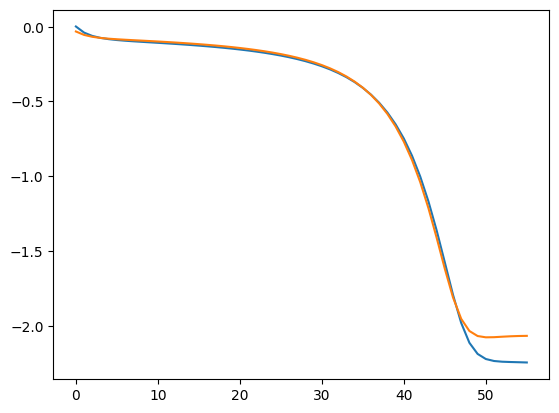

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [17]:
t_x_pred_dv = model.predict(X)

329/625 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


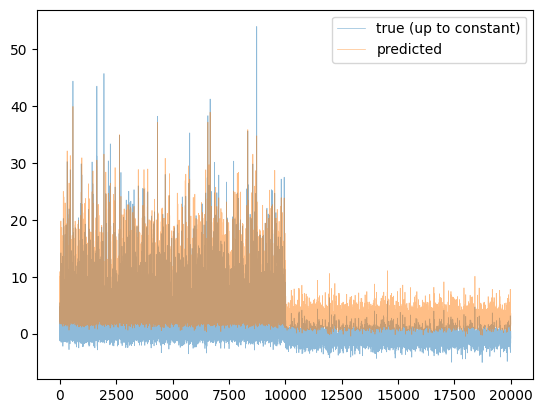

In [18]:
plt.plot(t_x_opt, label = "true (up to constant)", alpha=0.5, linewidth=0.5)
plt.plot(t_x_pred_dv, label="predicted", alpha=0.5, linewidth=0.5)
plt.legend()
plt.show()

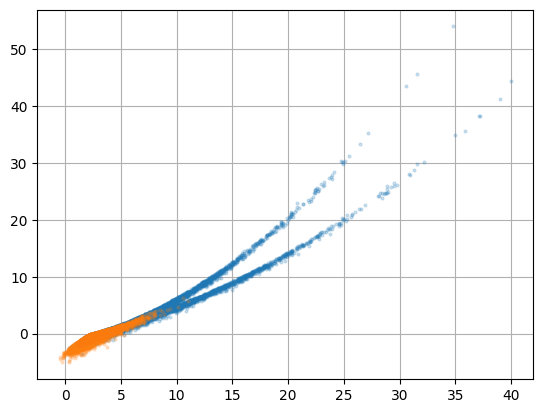

In [19]:
plt.plot(t_x_pred_dv[y == 1], t_x_opt[y == 1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred_dv[y == 0], t_x_opt[y == 0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [20]:
DV_fun(y, t_x_pred_dv)

2.0642343

In [21]:
X1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
X2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
X_new = np.concatenate((X1, X2), axis=0)
y_new = np.concatenate((np.ones(n), np.zeros(n)))

In [22]:
t_x_pred_dv_new = model.predict(X_new)
DV_fun(y_new, t_x_pred_dv_new)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


2.1714246

In [23]:
t_x_opt_new = np.apply_along_axis(T_opt, 1, X_new, mu1, mu2, Sigma1, Sigma2)
DV_fun(y_new, t_x_opt_new)

2.418344342083308

### f)

In [24]:
def NWJ_loss(y_true, T_x):
    first_term = tf.math.reduce_mean(T_x[y_true == 1])
    second_term = tf.math.reduce_mean(tf.math.exp(T_x[y_true == 0]-1))
    return -(first_term - second_term)

In [25]:
def NWJ_fun(y, t): 
    return np.mean(t[y==1]) - np.mean(np.exp(t[y==0]-1))

In [26]:
NWJ_fun(y, t_x_opt+1)

2.3371830913447598

In [27]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(48, activation="softplus")(model_inputs)
model_outputs = Dense(1)(layer_out)
model2 = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.AdamW(learning_rate=0.001)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

model2.compile(optimizer=optimizer, loss=NWJ_loss)

In [28]:
hist = model2.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0993 - val_loss: 0.6963
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5791 - val_loss: 0.2585
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1803 - val_loss: -0.0057
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0361 - val_loss: -0.0867
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0932 - val_loss: -0.0963
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1054 - val_loss: -0.1071
Epoch 7/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1193 - val_loss: -0.1183
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1321 - val_loss: -0.1301
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1452 - val_loss: -0.1431
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1593 - val_loss: -0.1573
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1747 - val_loss: -0.1728
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1917 - val_loss: -0.1899
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2102 - val_loss: -0.2086
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2306 - val_loss: -0.2292
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2530 - val_loss: -0.2519
Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.2777 - val_loss: -0.2769
Epoch 17/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.3050 - val_loss: -0.3046
Epoch 18/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

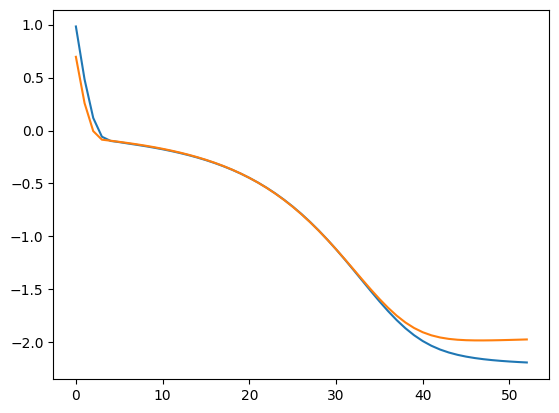

In [29]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [30]:
t_x_pred_nwj = model2.predict(X)
NWJ_fun(y, t_x_pred_nwj)

361/625 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


2.139985

In [31]:
t_x_pred_nwj_new = model2.predict(X_new)
NWJ_fun(y_new, t_x_pred_nwj_new)

355/625 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


2.2270803

## Summary - result comparison 

In [32]:
pd.DataFrame(
    {"X": 
    [
        KL_mult_normal(mu1, mu2, Sigma1, Sigma2),
        DV_fun(y, t_x_opt),
        DV_fun(y, t_x_pred_dv),
        NWJ_fun(y, t_x_opt+1),
        NWJ_fun(y, t_x_pred_nwj)
    ],
    "X_new":
    [
        KL_mult_normal(mu1, mu2, Sigma1, Sigma2),
        DV_fun(y_new, t_x_opt_new),
        DV_fun(y_new, t_x_pred_dv_new),
        NWJ_fun(y_new, t_x_opt_new+1),
        NWJ_fun(y_new, t_x_pred_nwj_new)
    ]
    },
    index=["KL", "KL (DV, log(p/q))",  "KL (DV, T_model)", "KL (NWJ, log(p/q)+1)", "KL (NWJ, T_model)"]
)

,X,X_new
KL,2.169076,2.169076
"KL (DV, log(p/q))",2.339947,2.418344
"KL (DV, T_model)",2.064234,2.171425
"KL (NWJ, log(p/q)+1)",2.337183,2.402662
"KL (NWJ, T_model)",2.139985,2.227080


We see that the KL divergence values estimated using neural networks are closer to the true KL divergence than the ones estimated using logarithms of the ratio of the densities. It is true for both considered representations (Donsker-Varadhan and Nguyen-Wainwright-Jordan). For first (training) sample NWJ-based estimate is closer to the true value, but for the second, new sample, the DV-based estimate is closer. 

It must be noted that training such neural networks can be hard as hyperparameters need to be set/tuned properly and the training process can be unstable. However, in general setting, we do not know the densities, so we have to follow the approach with neural networks. 